# Quantization Dithering - Mateusz Kliś
## Variant 3 - fsin = 300, fs = 2000

In [1]:
# importing libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

# audio write and play stuff
import soundfile as sf  # requires 'pip install soundfile'

In [2]:
# quantization function

def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

In [3]:
# cross corelation function

def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [4]:
# saturation

def check_my_quant(Q):
    N = 5e2
    x = 2*np.arange(N)/N - 1
    xq = my_quant(x, Q)
    e = xq - x

    plt.plot(x, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(x, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(x, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xticks(np.arange(-1, 1.25, 0.25))
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
C:\Users\klism\AppData\Local\Temp\ipykernel_9044\1586064171.py:21: SyntaxWarning: invalid escape sequence '\D'
  'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))


In [5]:
# dithering
def check_dithering(x,dither,Q,case):
    deltaQ=1/(Q//2)#generalrule
    #dithernoise
    pdf_dither, edges_dither=np.histogram(dither,bins='auto', density=True)
    xd=x+dither
    #quantization
    xq=my_quant(xd,Q)
    e=xq-x
    pdf_error,edges_error=np.histogram(e,bins='auto', density=True)
    #writewavs
    sf.write(file='x_'+case+'.wav',data=x,
    samplerate=48000,subtype='PCM_24')
    sf.write(file='xd_'+case+'.wav',data=xd,
    samplerate=48000,subtype='PCM_24')
    sf.write(file='xq_'+case+'.wav',data=xq,
    samplerate=48000,subtype='PCM_24')
    sf.write(file='e_'+case+'.wav',data=e,
    samplerate=48000,subtype='PCM_24')
    #CCF
    kappa,ccf=my_xcorr2(xq,e,scaleopt='biased')
    plt.figure(figsize=(12,3))
    if case=='nodither':
        plt.subplot(1,2,1)
        #nothingtoplotforthezerosignal
        #thePDFwouldbeaweightedDiracatamplitudezero
    else:
        #plotdithernoisePDFestimateashistogram
        plt.subplot(1,2,1)
        plt.plot(edges_dither[:-1],pdf_dither,'o-',ms=5)
        4
        plt.ylim(-0.1,np.max(pdf_dither)*1.1)
        plt.grid(True)
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$\hat{p}(\theta)$')
        plt.title('PDF estimate of dither noise')

    #ploterrornoisePDFestimateashistogram
    plt.subplot(1,2,2)
    plt.plot(edges_error[:-1],pdf_error,'o-',ms=5)
    plt.ylim(-0.1,np.max(pdf_error)*1.1)
    plt.grid(True)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\hat{p}(\theta)$')
    plt.title('PDF estimate of error noise')
    #plotsignals
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.plot(k,x,color='C2',label=r'$x[k]$')
    plt.plot(k,xd,color='C1',label=r'$x_d[k]=x[k]+dither[k]$')
    plt.plot(k,xq,color='C3',label=r'$x_q[k]$')
    plt.plot(k,e,color='C0',label=r'$e[k]=x_q[k]-x[k]$')
    plt.plot(k,k*0+deltaQ,':k',label=r'$DeltaQ$')
    plt.xlabel('k')
    plt.title('signals')
    plt.xticks(np.arange(0,175,25))
    plt.xlim(0,150)
    plt.legend(loc='lower left')
    plt.grid(True)
    #plotCCF
    plt.subplot(1,2,2)
    plt.plot(kappa,ccf)
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\varphi_{xq,e}[\kappa]$')
    plt.title('CCF between xq and e=xq-x')
    plt.xticks(np.arange(-100,125,25))
    plt.xlim(-100,100)
    plt.grid(True)

In [6]:
# defining parameters
fs = 2000
N = 2 * fs

k = np.arange(0, N)
fsin = 300

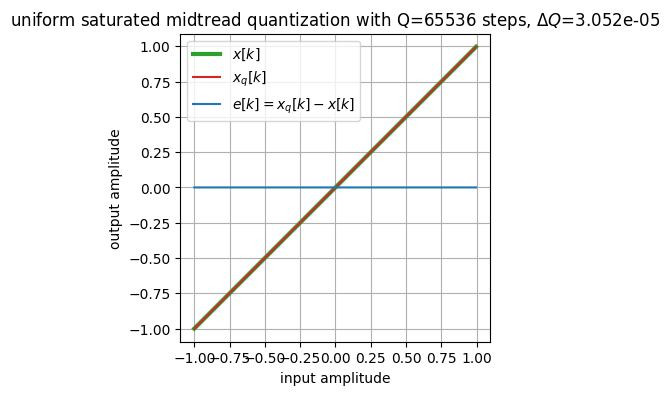

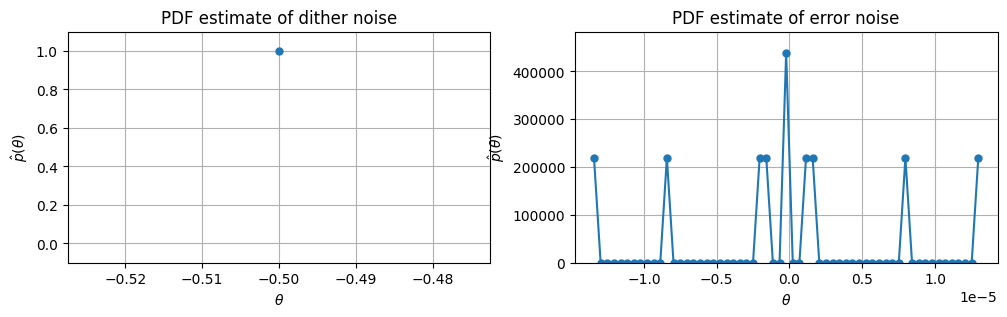

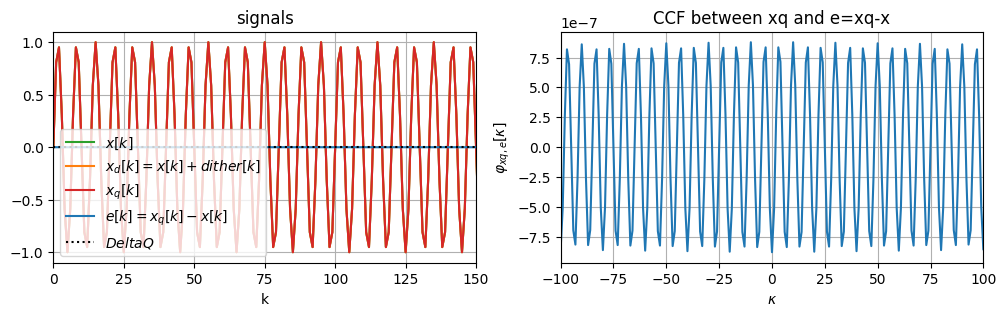

In [7]:
#case1
B=16 #Bit
Q=2**B #number of quantization steps
deltaQ=1/(Q//2) #quantization step size
x=(1-deltaQ)*np.sin(2*np.pi*fsin/fs*k) #largest positive amplitude

plt.figure(figsize=(4,4))
check_my_quant(Q)
check_dithering(x=x,dither=x*0,Q=Q,case='case1')

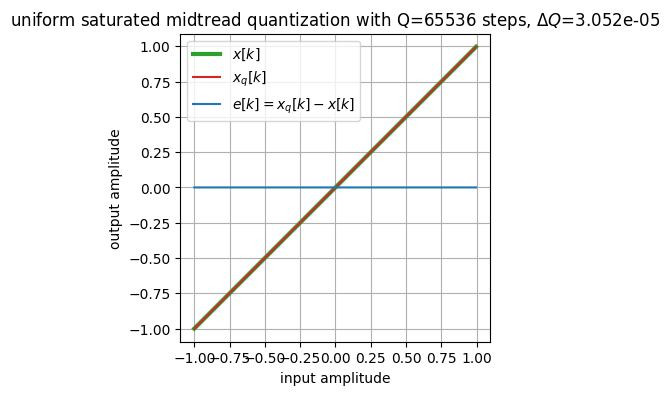

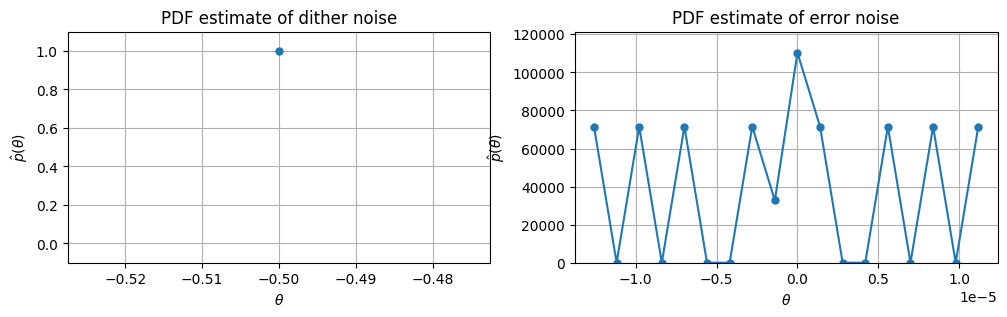

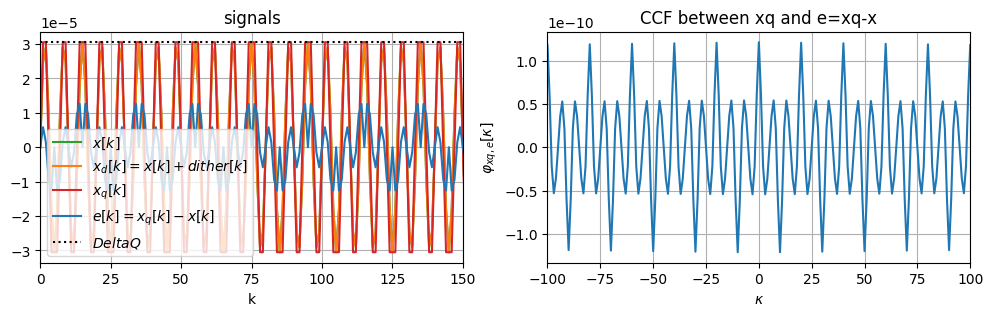

In [8]:
#case2
B=16
Q=2**B
deltaQ=1/(Q//2)
x=deltaQ*np.sin(2*np.pi*fsin/fs*k) #smallest amplitude

plt.figure(figsize=(4,4))
check_my_quant(Q)
check_dithering(x=x,dither=x*0,Q=Q,case='case2')

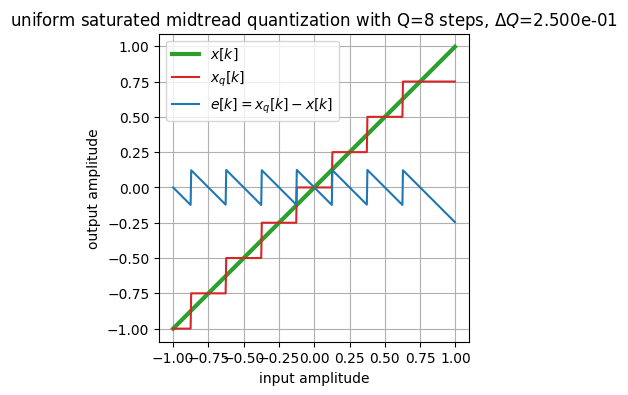

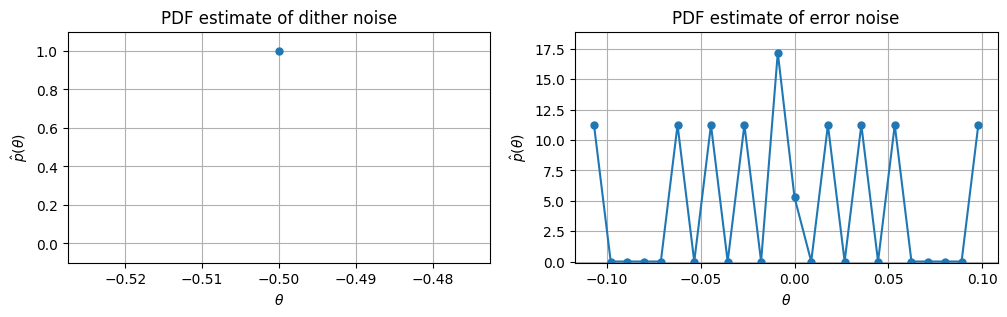

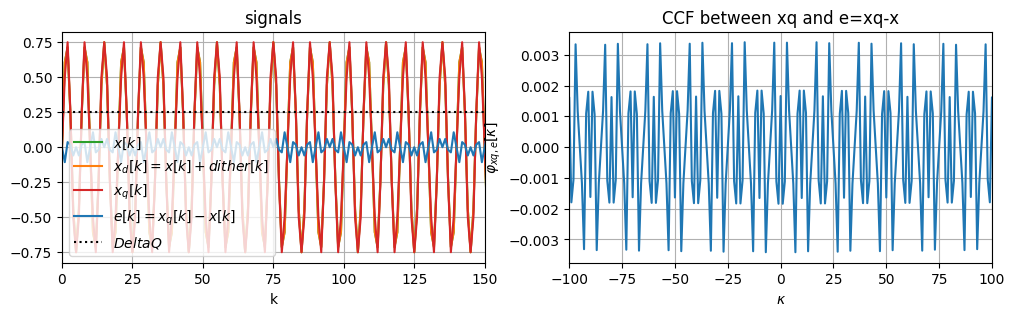

In [9]:
#case3
B=3
Q=2**B
deltaQ=1/(Q//2)
x=(1-deltaQ)*np.sin(2*np.pi*fsin/fs*k)

plt.figure(figsize=(4,4))
check_my_quant(Q)
check_dithering(x=x,dither=x*0,Q=Q,case='case3')

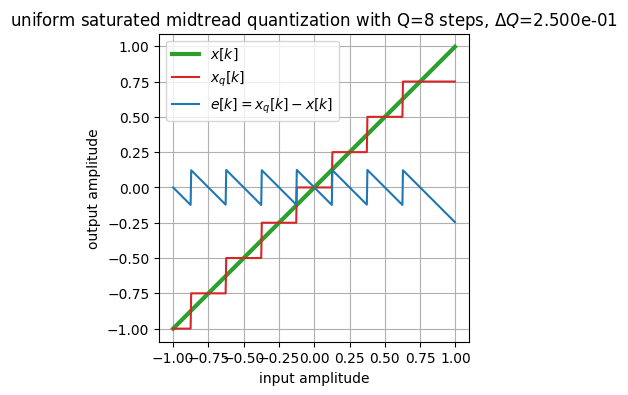

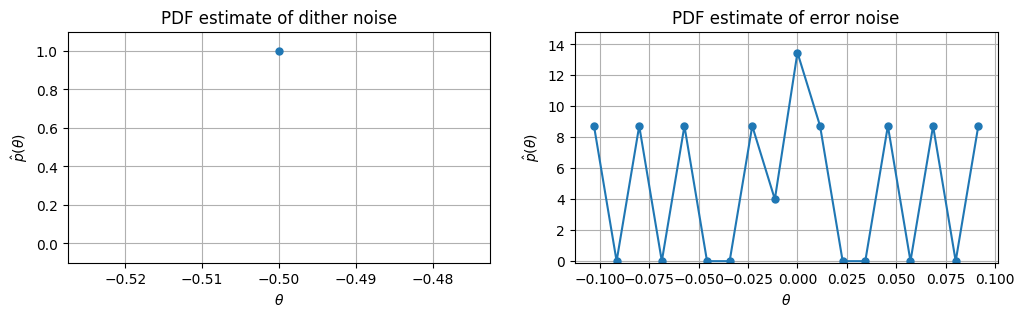

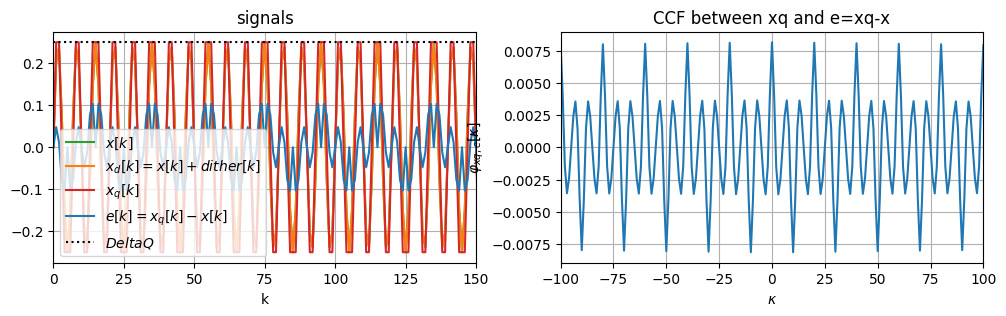

In [10]:
#case4
B=3
Q=2**B
deltaQ=1/(Q//2)
x=deltaQ*np.sin(2*np.pi*fsin/fs*k)

plt.figure(figsize=(4,4))
check_my_quant(Q)
check_dithering(x=x,dither=x*0,Q=Q,case='case4')

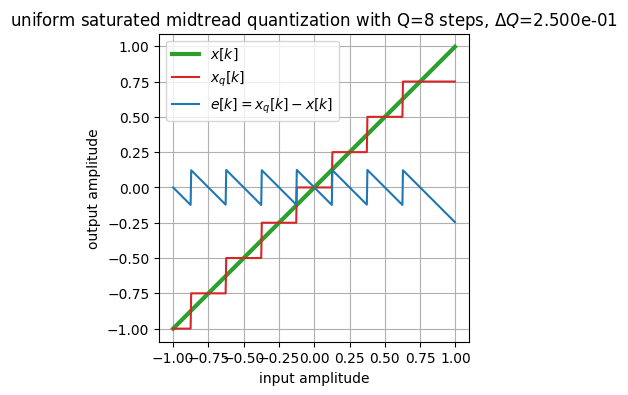

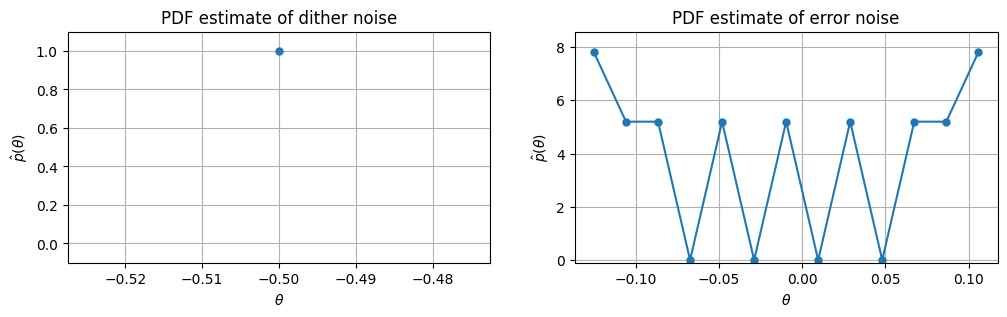

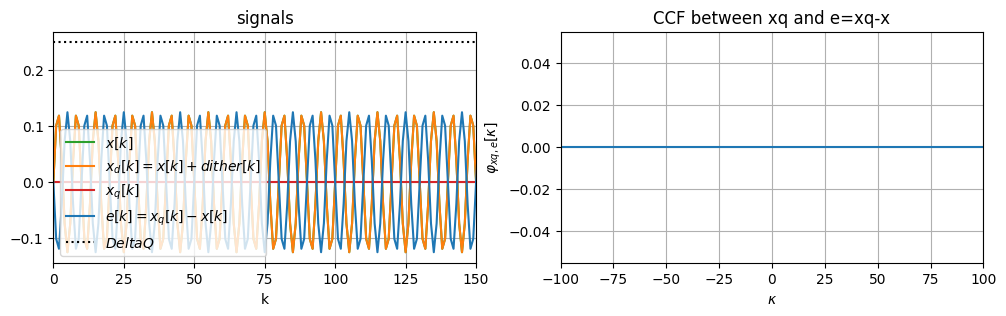

In [11]:
#case5
B=3
Q=2**B
deltaQ=1/(Q//2)
x=deltaQ/2*np.sin(2*np.pi*fsin/fs*k)

plt.figure(figsize=(4,4))
check_my_quant(Q)
check_dithering(x=x,dither=x*0,Q=Q,case='case5')